## HW4: Simulation of Human Neutrophil Elastase (HNE) system
### Goal: run a series of simulations of human neutrophil elastase (HNE)

In [ ]:
$ srun -c4 -t4:00:00 --mem=4000 --pty /bin/bash 

In [ ]:
$ module load amber/openmpi/intel/22.03

# openmpi/gcc/3.1.4
# openmpi/gcc/4.0.5
# openmpi/intel/4.0.5
# openmpi/intel/4.1.1

# amber/openmpi/intel/20.06
# amber/openmpi/intel/20.11                      
# amber/openmpi/intel/22.00                     
# amber/openmpi/intel/22.03

In [ ]:
$ wget https://files.rcsb.org/view/2Z7F.pdb

#### Obtain and parse the PDB file

In [ ]:
# 2Z7F.pdb contains chain E, chain I, and two ligands(NAG and FUC)
# Keep only chain E, extract chain I from the original PDB fil
# The -v option inverts the match, so egrep -v will exclude chain "I"

$ grep "ATOM " 2Z7F.pdb | egrep -v " I " > 2z7f_chainE.pdb

In [ ]:
$ grep "HOH " 2Z7F.pdb | egrep -v " I " > 2z7f_chainE_XWAT.pdb

#### Protonate the protein

In [ ]:
# Protonate the protein using  PDB2PQR webserver (https://server.poissonboltzmann.org/pdb2pqr)
# Generate the 2z7f_chainE.pqr

# PARSE force field
# AMBER naming scheme
# PROPKA as pKa option
# checked the settings: (1) "Ensure that new atoms are not rebuilt too close to existing atoms", and (2) "Optimize the hydrogen bonding network".

#### Add crystal waters, disulfide bonds, solvate the system, and prepare prmtop and inpcrd files using tleap

In [ ]:
$ tleap

In [ ]:
# loads FF14SB the force field parameters for proteins

$ source leaprc.protein.ff14SB

In [ ]:
# loads the parameters for the TIP3P water model

$ source leaprc.water.tip3p

In [ ]:
# loads the GAFF force field for small organic molecules 

$ source leaprc.gaff2

In [ ]:
# Load the protein

$ prot = loadpdb 2z7f_chainE.pqr

# Loading PDB file: ./2z7f_chainE.pqr
# total atoms in file: 3292

In [ ]:
# Renumber the protein residue starting from 1 instead of 16 in .pqr file
# Make the numbering continuously instead of missing some residues
# For the uncertain residue, keep the first one by defualt 
# Generate 2z7f_chainE_renum.pdb file

$ savepdb prot 2z7f_chainE_renum.pdb

# Warning:  Converting N-terminal residue name to PDB format: NILE -> ILE
# Warning:  Converting C-terminal residue name to PDB format: CGLN -> GLN

In [ ]:
$ quit

# Exiting LEaP: Errors = 0; Warnings = 2; Notes = 0.

### Bond the disulfide in tleap

In [ ]:
$ tleap

In [ ]:
$ source leaprc.protein.ff14SB

In [ ]:
$ source leaprc.gaff2

In [ ]:
$ prot = loadpdb 2z7f_chainE_renum.pdb

# Loading PDB file: ./2z7f_chainE_renum.pdb
# total atoms in file: 3292

In [ ]:
# check the bonding information of one sulfide atom for example Cys26@SG

$ desc prot.26.SG

# Bonded to .R<CYX 26>.A<CB 5> by a single bond.

In [ ]:
# bond disulfide bond

$ bond prot.26.SG prot.42.SG

In [ ]:
# check the bonding information again

$ desc prot.26.SG

# Bonded to .R<CYX 26>.A<CB 5> by a single bond.
# Bonded to .R<CYX 42>.A<SG 8> by a single bond.

In [ ]:
# Bond other disulfide bonds

$ bond prot.169.SG prot.194.SG
$ bond prot.152.SG prot.158.SG
$ bond prot.122.SG prot.179.SG


In [ ]:
$ xwat = loadpdb 2z7f_chainE_XWAT.pdb

# Loading PDB file: ./2z7f_chainE_XWAT.pdb
#   total atoms in file: 196
#   Leap added 392 missing atoms according to residue templates:
#        392 H / lone pairs

In [ ]:
# combine the protein and waters

$ complex = combine {prot xwat}

In [ ]:
# save amber topology and coordinate files

$ saveamberparm prot HNE_noWAT.prmtop HNE_noWAT.inpcrd

# Warning: The unperturbed charge of the unit (12.000000) is not zero.
# Marking per-residue atom chain types.
#   (Residues lacking connect0/connect1 - 
#    these don't have chain types marked:

#         res     total affected

#         CGLN    1
#         NILE    1
#   )

In [ ]:
# check the charge of the complex system and we need to add ions to neutralize it

$ charge complex

# Total unperturbed charge:  12.000000
# Total perturbed charge:    12.000000

In [ ]:
# add Cl- ions to balance out the charges

$ addions2 complex Cl- 0

# 12 Cl- ions required to neutralize.
# Adding 12 counter ions to "complex" using 1A grid
# Grid extends from solute vdw + 2.51  to  8.51
# Resolution:      1.00 Angstrom.
# Calculating grid charges
# Placed Cl- in complex at (38.01, 116.51, 18.40).
# Placed Cl- in complex at (29.01, 117.51, 24.40).
# Placed Cl- in complex at (16.01, 112.51, -6.60).
# Placed Cl- in complex at (37.01, 121.51, 10.40).
# Placed Cl- in complex at (32.01, 93.51, 32.40).
# Placed Cl- in complex at (28.01, 118.51, 15.40).
# Placed Cl- in complex at (33.01, 123.51, 0.40).
# Placed Cl- in complex at (36.01, 110.51, 27.40).
# Placed Cl- in complex at (41.01, 88.51, 18.40).
# Placed Cl- in complex at (15.01, 110.51, 21.40).
# Placed Cl- in complex at (25.01, 77.51, 19.40).
# Placed Cl- in complex at (24.01, 113.51, 29.40).

In [ ]:
# solvate the protein in a TIP3P water box, and we want at least 12 A between our protein 
# surface and the edge of the water box

$ solvatebox complex TIP3PBOX 12.0 

#   Solute vdw bounding box:              41.355 51.026 54.159
#   Total bounding box for atom centers:  65.355 75.026 78.159
#   Solvent unit box:                     18.774 18.774 18.774
#   Total vdw box size:                   68.705 77.891 81.106 angstroms.
#   Volume: 434035.967 A^3 
#   Total mass 213271.064 amu,  Density 0.816 g/cc
#   Added 10325 residues.

In [ ]:
# check the structures and it will show some information or warning or errors.

$ check complex

# check:  Warnings: 37
# Unit is OK.

In [ ]:
# save solvated complex

$ saveamberparm complex HNE_sol.prmtop HNE_sol.inpcrd

In [ ]:
# save a pdb of the solvated HNC system

$ savepdb complex HNC_sol0.pdb

# Exiting LEaP: Errors = 0; Warnings = 40; Notes = 1.

### Minimization of the system

$ srun --tasks-per-node=4 --time=2:00:00 --mem=4GB --pty /bin/bash

In [ ]:
# Create min_sol.in file for minimization of waters
    """
Minimization of water molecules
&cntrl
imin = 1,
maxcyc=5000,
ncyc=3000,
ntb=1,
cut=10,
ntpr=5,
ntr=1, restraintmask=':1-218',
restraint_wt=2.0,
/
    """

In [ ]:
# Create min_all.in file minimization of the whole system
    """
Minimization of the whole system
&cntrl
imin = 1,
maxcyc=10000, ncyc=7000,
ntb=1, ntr=0, cut=10, ntpr=5,
/
    """

In [ ]:
$ module swap amber/openmpi/intel/22.03 amber/openmpi/intel/22.00

In [ ]:
$ mpiexec pmemd.MPI -O -i min_sol.in -o min_sol.out -p HNE_sol.prmtop -c HNE_sol.inpcrd -r min_sol.rst -ref HNE_sol.inpcrd 

In [ ]:
$ mpiexec pmemd.MPI -O -i min_all.in -o min_all.out -p HNE_sol.prmtop -c min_sol.rst -r min_all.rst -ref min_sol.rst

### Data Analysis

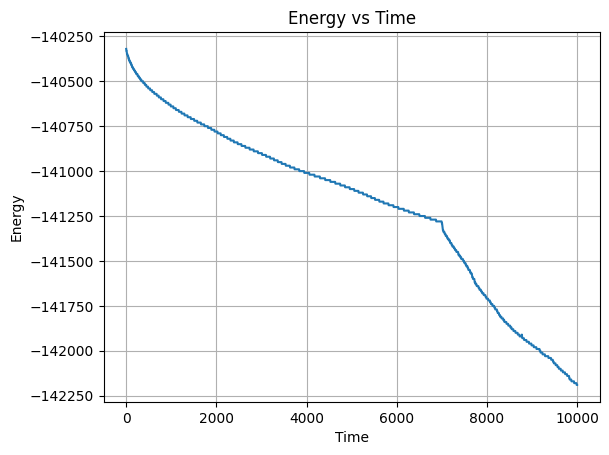

In [6]:
import matplotlib.pyplot as plt

# Specify the file path
file_path = "min/minall/summary.ENERGY"

# Read data from file
time = []
energy = []
with open(file_path, 'r') as file:
    for line in file:
        columns = line.split()
        time.append(float(columns[0]))
        energy.append(float(columns[1]))

# Plot the graph
plt.plot(time, energy)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time')
plt.grid(True)
plt.show()

